In [3]:
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, BatchNormalization, \
    LeakyReLU, Reshape, Flatten
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.optimizer_v2.adam import Adam

In [ ]:
print(f"Tensorflow: {tensorflow.__version__}")
print(f"Keras: {tensorflow.keras.__version__}")

In [4]:
def get_discriminator(input_size=(250, 450, 3)):
    model = Sequential()

    model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_size))
    model.add(Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Flatten())
    model.add(Dense(1))
    return model

In [14]:
def get_generator(input_dim=100):
    gen_input = Input(input_dim)
    init = LeakyReLU()(BatchNormalization()(Dense(16 * 29 * 1024, input_dim=input_dim, use_bias=False)(gen_input)))
    init = Reshape((16, 29, 1024))(init)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(init)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = Concatenate(axis=3)([up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up1 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up3 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    output = Resizing(height=250, width=450)(conv9)
    model = Model(inputs=[gen_input], outputs=[output])

    model.compile(optimizer=Adam(learning_rate=3e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [15]:
def get_gan(disc, gen):
    disc.trainable = False
    model = Sequential(name="generator")
    model.add(gen)
    model.add(disc)
    opt = Adam(learning_rate=2e-4, beta_1=0.05)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15, 28, 1024 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 15, 28, 1024) 9438208     input_4[0][0]                    
__________________________________________________________________________________________________
up_sampling2d_10 (UpSampling2D) (None, 30, 56, 1024) 0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 30, 56, 512)  2097664     up_sampling2d_10[0][0]           
____________________________________________________________________________________________

In [1]:
generator = get_generator()
generator.summary()

NameError: name 'get_discriminator' is not defined

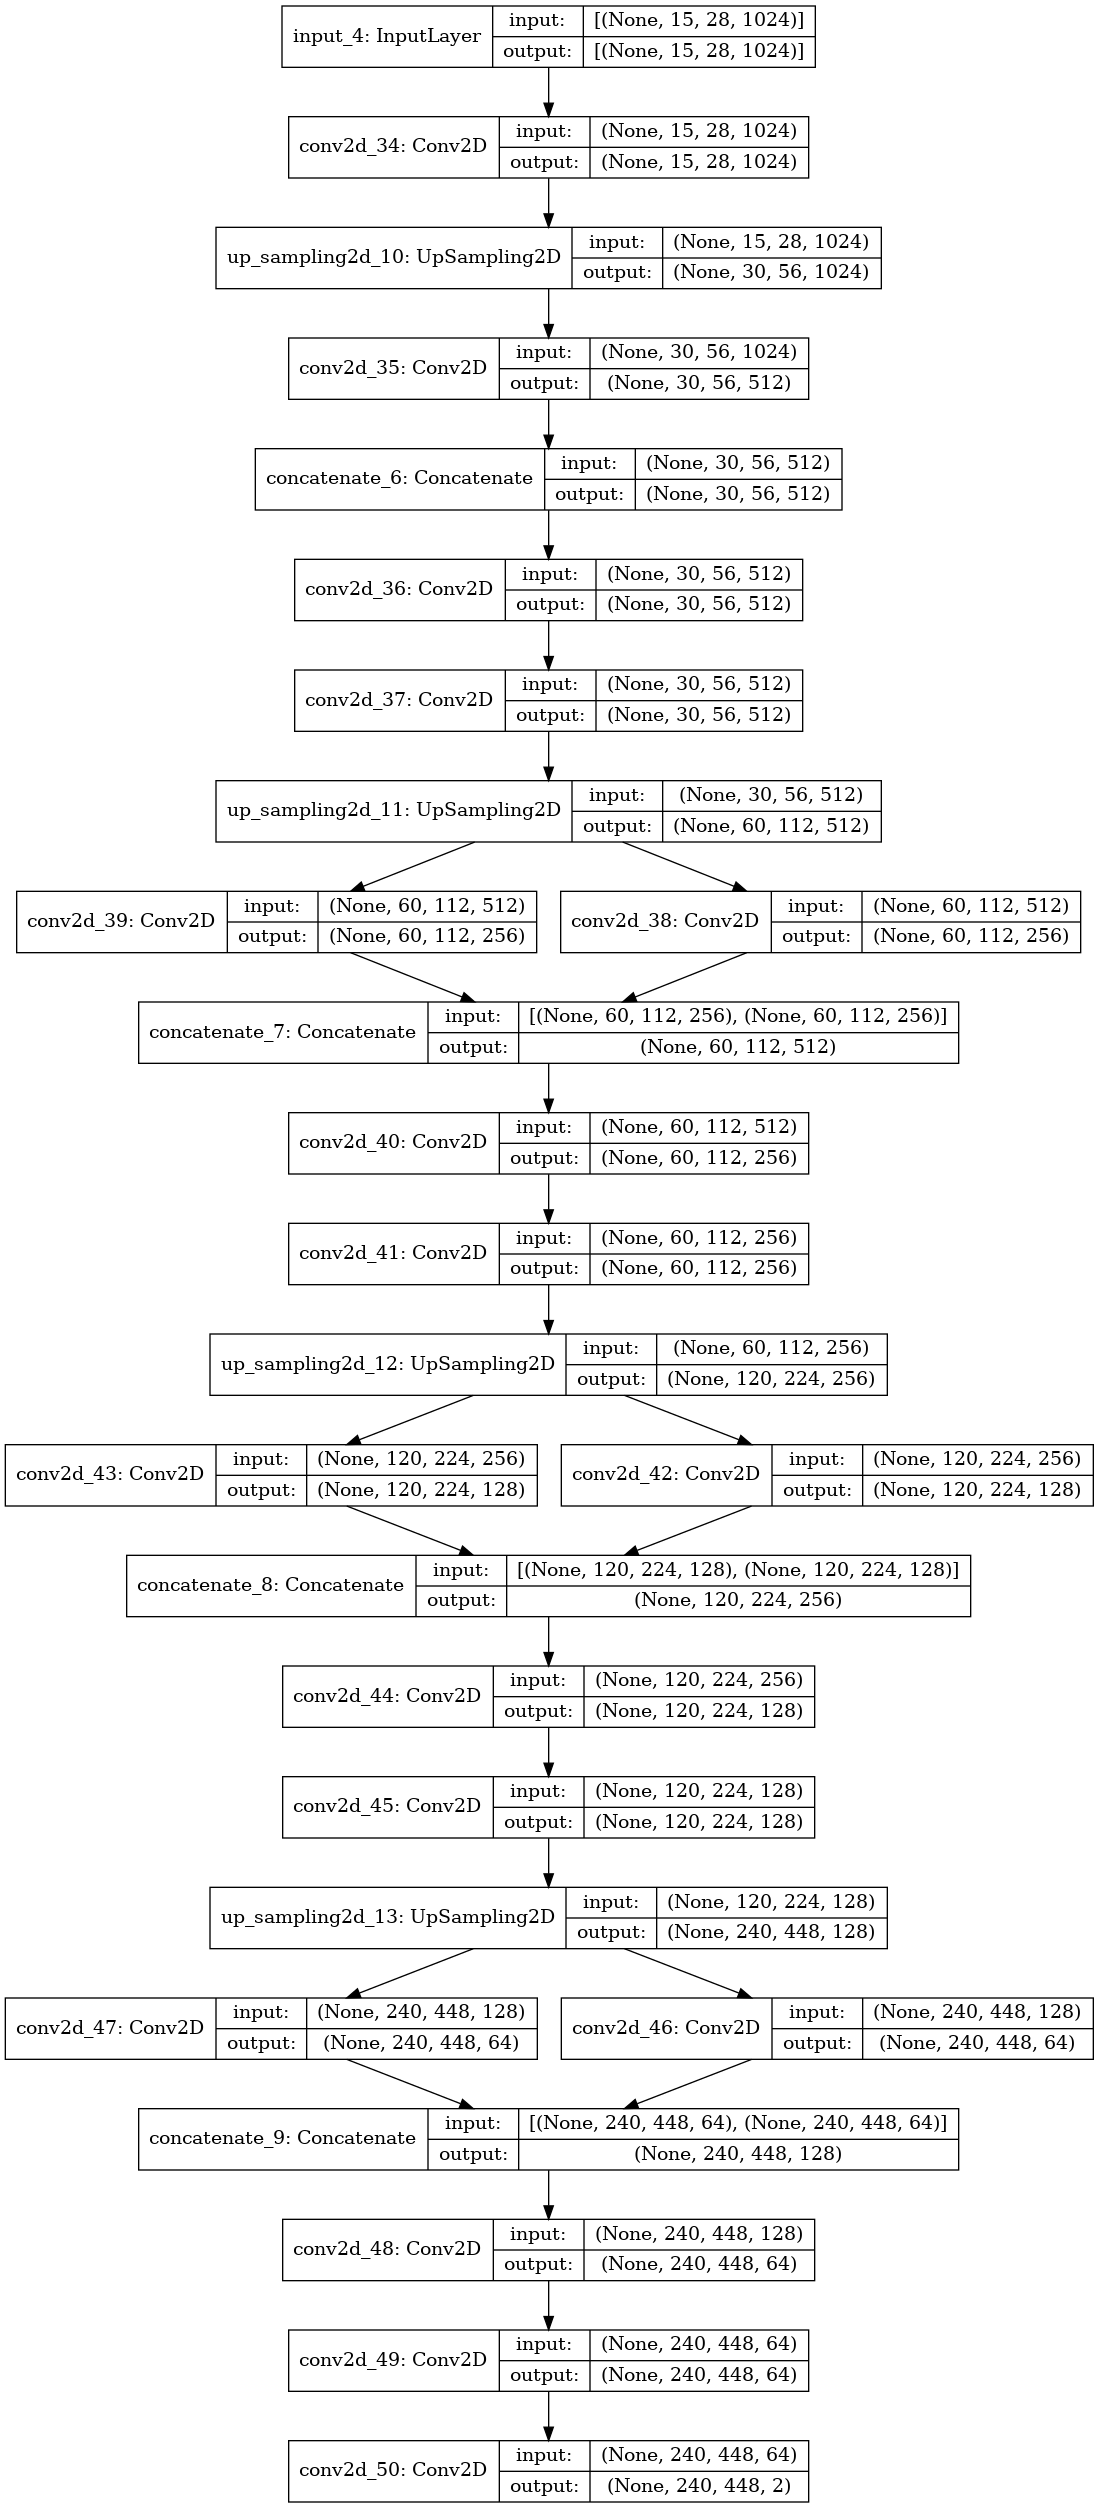

In [17]:
disc = get_discriminator()
disc.summary()

In [ ]:
gan = get_gan(disc, generator)
gan.summary()

In [ ]:
plot_model(disc, "discriminator.png", show_shapes=True)
plot_model(generator, "generator.png", show_shapes=True)
plot_model(gan, "gan.png", show_shapes=True)